In [36]:
import matplotlib.pyplot as plt
from functools import partial
import pandas as pd
import numpy as np
import tarfile 
import os

from google.colab import drive
drive.mount('/content/drive')

In [3]:
def add_path(file_, path):
  '''
  add the images folder to the file name

  Args:
    file_ (str) --> file that is inside the folder
    path (str) --> folder that contains the files
  
  Returns:
    filepath (str) --> file with destination path
  '''

  return path + file_

In [4]:
!cp -r /content/drive/MyDrive/datasets/nih-files /content

In [5]:
extract_files = os.listdir('/content/nih-files')

for files in extract_files:
  file_ = tarfile.open(f'/content/nih-files/{files}') 
  file_.extractall('/content/') 
  file_.close() 

In [27]:
nih_df = pd.read_csv('/content/Data_Entry_2017_v2020.csv')
nih_df = nih_df.drop(['Follow-up #', 'Patient ID', 'Patient Age', 
                      'View Position', 'OriginalImage[Width', 'Height]', 
                      'OriginalImagePixelSpacing[x', 'y]'], axis = 1)

In [28]:
nih_df.rename(columns = {'Patient Gender': 'Sex'}, inplace = True)
nih_df['Sex'].replace({'M': 'male', 'F': 'female'}, inplace = True)

image_index = list(nih_df['Image Index'])
partial_add_path = partial(add_path, path = '/content/images/')
image_index = list(map(partial_add_path, image_index))

nih_df['Path'] = image_index
nih_df = nih_df.drop(['Image Index'], axis = 1)
nih_df['Dataset'] = ['NIH'] * len(nih_df)
nih_df['Label Type'] = ['Multiclass'] * len(nih_df)

In [ ]:
classes = ['No Finding',  'Nodule', 'Effusion', 'Atelectasis',  'Pneumothorax',
           'Mass']

dict_abnormalities = dict()
for classe in classes:
  dict_abnormalities[classe] = nih_df[nih_df['Finding Labels'] == classe]

for keys, items in dict_abnormalities.items():
  dict_abnormalities[keys][keys] = [1] * len(items)
  columns_others = list(dict_abnormalities.keys())
  columns_others.remove(keys)
  zeros = np.zeros((len(items), 5))
  others_df = pd.DataFrame(data = zeros, columns = columns_others)
  dict_abnormalities[keys] = dict_abnormalities[keys].join(others_df)
  dict_abnormalities[keys] = dict_abnormalities[keys].fillna(0)
  columns = np.concatenate((['Dataset', 'Path', 'Sex', 'Finding Labels', 
                             'Label Type'], list(dict_abnormalities.keys())))
  dict_abnormalities[keys] = dict_abnormalities[keys][columns]

In [30]:
for index, sub in enumerate(dict_abnormalities.keys()):
  if index == 0:
    nih_df = dict_abnormalities[sub]
  elif index != len(dict_abnormalities):
    nih_df = pd.concat((nih_df, dict_abnormalities[sub]))

nih_df = nih_df.drop(['Finding Labels'], axis = 1)

In [33]:
count_findings = list()
for finding in classes:
  count = list(nih_df[finding].value_counts())[1]
  count_findings.append(count)
  
min_classe = min(count_findings)
sub_nih_df = list()
for index, finding in enumerate(classes):
  sub_nih_df.append(nih_df[nih_df[finding] == 1])
  sub_nih_df[index] = sub_nih_df[index].sample(n = min_classe)

for index, sub in enumerate(sub_nih_df):
  if index == 0:
    nih_df = sub
  elif index != len(sub_nih_df):
    nih_df = pd.concat((nih_df, sub))

Text(0.5, 1.0, 'Quantidade Total de Imagens: Base de Dados NIH - Multiclasse')

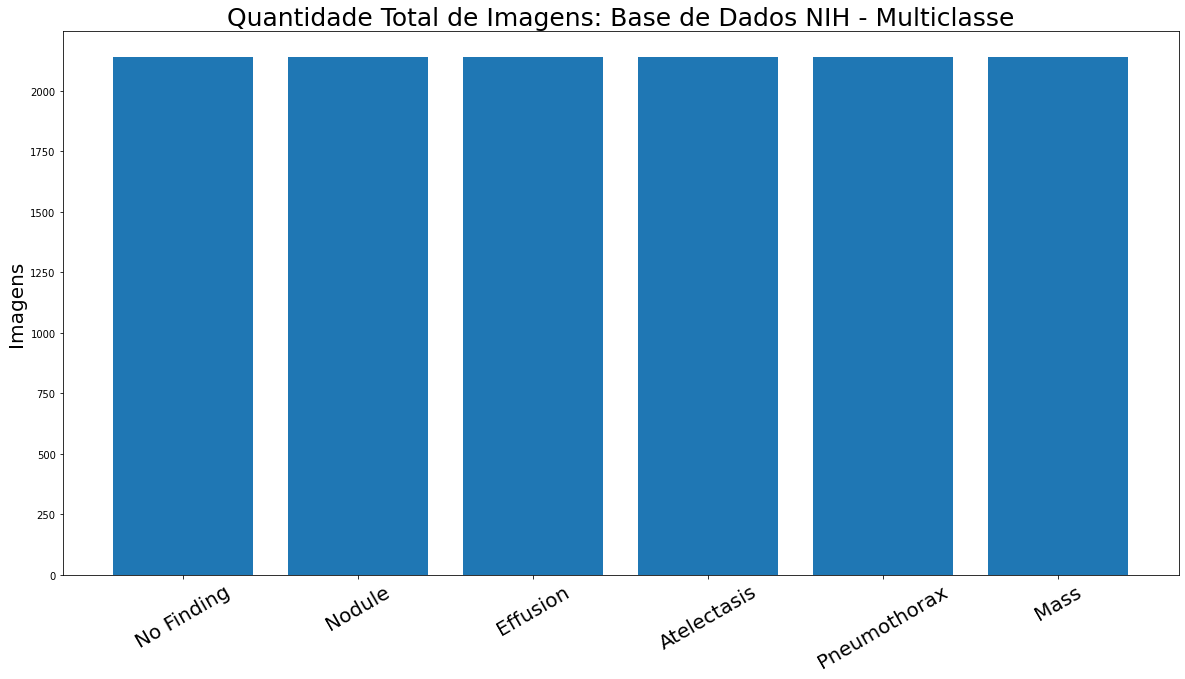

In [39]:
count_findings = list()
for finding in classes:
  count = list(nih_df[finding].value_counts())[1]
  count_findings.append(count)

plt.figure(figsize = (20, 10))
plt.bar(classes, count_findings)
plt.xticks(rotation = 30, size = 20)
plt.ylabel('Imagens', size = 20)
plt.title('Quantidade Total de Imagens: Base de Dados NIH - Multiclasse', 
          size = 25)

In [42]:
columns = np.concatenate((['Dataset', 'Path', 'Sex', 'Label Type'],  classes))
nih_df.to_csv(path_or_buf = 'nih_df.csv', columns = columns)